[FPL Optimized link](http://fploptimized.com/)

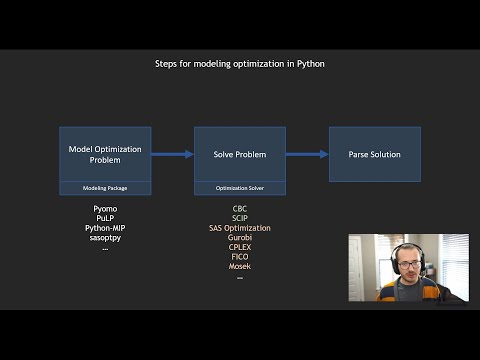

In [1]:
from IPython.lib.display import YouTubeVideo

YouTubeVideo('DFXCXoR6Dvw')

In [2]:
import os
import sasoptpy as so
import pandas as pd


DATA_DIR = os.path.join('data', 'fplreview')

In [3]:
# load all players' GW36 projections
df = pd.read_csv(os.path.join(DATA_DIR, 'gw36.csv'))
df.columns = ['Pos', 'Name', 'BV', 'SV', 'Team', 'xMins', 'Pts']

# filter dataframe to only goalkeepers
df = df[df['Pos'] == 'G']

# show top 5 projections
df.sort_values('Pts', ascending=False).head()

,Pos,Name,BV,SV,Team,xMins,Pts
156,G,Pickford,4.8,4.8,Everton,89,4.390
277,G,Ederson,6.1,6.1,Man City,89,4.360
382,G,Lloris,5.6,5.6,Spurs,89,4.274
251,G,Alisson,5.9,5.9,Liverpool,89,4.254
11,G,Martínez,5.4,5.2,Aston Villa,89,3.761


In [4]:
def solve_gk_problem(gk_data, budget):
    
    model = so.Model(name='gk_model')
    players = gk_data.index.tolist()
    
    # Variables
    lineup = model.add_variables(players, name='lineup', vartype=so.binary)
    bench = model.add_variables(players, name='bench', vartype=so.binary)
    # Objective
    total_xp = so.expr_sum(lineup[p] * gk_data.loc[p, 'Pts'] for p in players) +\
        0.1 * so.expr_sum(bench[p] * gk_data.loc[p, 'Pts'] for p in players)
    model.set_objective(-total_xp, name='total_xp_obj', sense='N')
    # Contraints
    # A player cannot be selected twice (bench and starting)
    model.add_constraints((lineup[p] + bench[p] <= 1 for p in players),
                          name='max_selections')
    # Must have exactly one starting GK
    model.add_constraint(so.expr_sum(lineup[p] for p in players) == 1,
                         name='single_lineup')
    # Must have one GK on bench
    model.add_constraint(so.expr_sum(bench[p] for p in players) == 1,
                         name='single_bench')
    # Combined value of players cannot exceed budget
    model.add_constraint(
        so.expr_sum(
            (lineup[p] + bench[p]) * gk_data.loc[p, 'BV'] for p in players
        ) <= budget, name='max_budget'
    )
    # Solve Step
    model.export_mps(filename='gk.mps')
    command = 'cbc gk.mps solve solu solution.txt'
    os.system(command)
    with open('solution.txt', 'r') as f:
        for v in model.get_variables():
            v.set_value(0)
        for line in f:
            if 'objective value' in line:
                continue
            words = line.split()
            var = model.get_variable(words[1])
            var.set_value(float(words[2]))
    print("LINEUP")
    for p in players:
        if lineup[p].get_value() > 0.5:
            print(p, gk_data.loc[p])
    print("BENCH")
    for p in players:
        if bench[p].get_value() > 0.5:
            print(p, gk_data.loc[p])

In [5]:
solve_gk_problem(df, 10)

NOTE: Initialized model gk_model.
LINEUP
156 Pos             G
Name     Pickford
BV            4.8
SV            4.8
Team      Everton
xMins          89
Pts          4.39
Name: 156, dtype: object
BENCH
212 Pos            G
Name     Meslier
BV           4.7
SV           4.7
Team       Leeds
xMins         89
Pts         3.71
Name: 212, dtype: object
